In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9

In [2]:
def generate_observed_params(nsamples, truth=False):

    if(truth == False):
        logphi1 = np.random.normal([-2.44, -3.08, -4.14], [0.04, 0.05, 0.2], (nsamples, 3))
        logphi2 = np.random.normal([-2.89, -3.29, -3.51], [0.07, 0.06, 0.06], (nsamples, 3))
        logm_star = np.random.normal([10.79, 10.88, 10.84], [0.04, 0.04, 0.08], (nsamples, 3))
        alpha1 = np.random.uniform(-0.5 , 1, nsamples)
        alpha2 = np.random.uniform(-2 , -0.5, nsamples)
        #alpha1 = np.random.normal(-0.28 , 0.14, nsamples)
        #alpha2 = np.random.normal(-1.48 , 0.04, nsamples)
    else:
        logphi1 = np.array([[-2.44, -3.08, -4.14]])
        logphi2 = np.array([[-2.89, -3.29, -3.51]])
        logm_star = np.array([[10.79, 10.88, 10.84]])
        alpha1 = np.array([[-0.28]])
        alpha2 = np.array([[-1.48]])

    return [logphi1, logphi2, logm_star, alpha1, alpha2]

In [3]:
def get_quadratic_coeffs(samples):

    y1 = samples[:, 2]
    y2 = samples[:, 1]
    y3 = samples[:, 0]

    z1 = 3.0
    z2 = 1.6
    z3 = 0.2

    a = ((y3-y1) + ((y2-y1) / (z2-z1)) * (z1-z3)) / ((z3**2-z1**2 + ((z2**2-z1**2) / (z2-z1)) * (z1-z3)))
    b = ((y2-y1) - a * (z2**2-z1**2)) / (z2-z1)
    c = y1-a*z1**2-b*z1

    return np.transpose(np.vstack((a, b, c)))


In [4]:
def mass_function_parameters(z, nsamples):

    observed_mass_function_parameters = generate_observed_params(nsamples)
    redshift_dependent_parameters = observed_mass_function_parameters[:3]
    alpha1 = observed_mass_function_parameters[3]
    alpha2 = observed_mass_function_parameters[4]

    coeffs = []
    for parameter in redshift_dependent_parameters:
        coeffs.append(get_quadratic_coeffs(parameter))

    logphi1_coeffs = coeffs[0]
    logphi2_coeffs = coeffs[1]
    logm_star_coeffs = coeffs[2]

    logphi1_z = logphi1_coeffs[:, 2] + logphi1_coeffs[:, 1]*z + logphi1_coeffs[:, 0]*z*z
    logphi2_z = logphi2_coeffs[:, 2] + logphi2_coeffs[:, 1]*z + logphi2_coeffs[:, 0]*z*z
    logm_starparams_z = logm_star_coeffs[:, 2] + logm_star_coeffs[:, 1]*z + logm_star_coeffs[:, 0]*z*z 

    return np.transpose(np.vstack((logphi1_z, logphi2_z, logm_starparams_z, alpha1, alpha2)))


In [5]:
def mass_function_parameter_curves(z_grid, nsamples, truth):

    observed_mass_function_parameters = generate_observed_params(nsamples, truth)
    redshift_dependent_parameters = observed_mass_function_parameters[:3]
    alphas = observed_mass_function_parameters[3:]

    curves = []
    for param in redshift_dependent_parameters:
        coeffs = get_quadratic_coeffs(param)
        a = np.reshape(coeffs[:, 0], (nsamples, 1))
        b = np.reshape(coeffs[:, 1], (nsamples, 1))
        c = np.reshape(coeffs[:, 2], (nsamples, 1))
        z_grid_tile = np.tile(z_grid, (nsamples, 1))

        logparam = c*np.ones_like(z_grid_tile) + b*z_grid_tile + a*z_grid_tile*z_grid_tile
        curves.append(logparam)

    for aparam in alphas:
        z_grid_tile = np.tile(z_grid, (nsamples, 1))
        alpha_param = np.reshape(aparam, (nsamples, 1))
        alpha_param = alpha_param*np.ones_like(z_grid_tile)
        curves.append(alpha_param)

    return curves

In [6]:
def plot_mass_function_parameter_curves(z_grid, curves, **kwargs):

    fig, axes = plt.subplots(1, 5)
    fig.set_figheight(10)
    fig.set_figwidth(30)
    ylabels = ['log$_{10}\phi_{1}$', 'log$_{10}\phi_{2}$', 'log$_{10}\mathrm{M}_{*}$',r'$\alpha_{1}$', r'$\alpha_{2}$']
    ncurves = curves[0].shape[0]
    plot_no = 0
    for param in curves:
        i = 0
        while(i < ncurves):
            axes[plot_no].plot(z_grid, param[i, :], c='purple', **kwargs)
            axes[plot_no].set_xlabel('$z$', fontsize=20)
            axes[plot_no].set_ylabel(ylabels[plot_no], fontsize=20)
            i+=1
        plot_no+=1

In [7]:
def schechter(logm, logphi, logm_star, alpha):

    ones = np.ones_like(alpha)
    
    return np.log(10)*(10**logphi)*10**((logm-logm_star)*(alpha+ones))*np.exp(-10**(logm-logm_star))

def mass_function(z, logm, nsamples, truth=False):

    nmasses = len(logm)
    logphi1, logphi2, logm_star, alpha1, alpha2 = mass_function_parameter_curves(z, nsamples, truth)

    logphi1 = np.tile(logphi1, (nmasses, 1, 1))
    logphi2 = np.tile(logphi2, (nmasses, 1, 1))
    logm_star = np.tile(logm_star, (nmasses, 1, 1))
    alpha1 = np.tile(alpha1, (nmasses, 1, 1))
    alpha2 = np.tile(alpha2, (nmasses, 1, 1))

    logm = np.reshape(logm, (nmasses, 1, 1))

    return schechter(logm, logphi1, logm_star, alpha1) + schechter(logm, logphi2, logm_star, alpha2)

In [8]:
def plot_observed_mass_function():
    
    z_grid = np.linspace(0.0, 2.0, 5)
    logm_grid = np.linspace(8, 12, 100)
    mass_func = np.split(mass_function(z_grid, logm_grid, 1, truth=True), 5, axis=2) #axis=0, is logm, axis=1 is samples, axis=2 is z

    colours = plt.cm.Reds(np.linspace(0,1,len(z_grid)))

    i = 0
    for fun in mass_func:
        plt.plot(logm_grid, np.log10(np.reshape(fun, (100,))), color=colours[i], label=str(z_grid[i]))
        i+=1

    plt.ylim(-5, -1)
    plt.xlabel('log(M/M*)')
    plt.ylabel('log($\Phi$/Mpc-3/dex)')
    plt.legend()

In [9]:
def volume_element(z, dz):
    return WMAP9.comoving_volume(z+dz).value - WMAP9.comoving_volume(z).value

In [10]:
def volume_elements(z_grid):

    dz = z_grid[-1]-z_grid[-2]
    volumes = []
    for z in z_grid:
        volumes.append(volume_element(z, dz))

    return np.array(volumes)

In [11]:
def plot_observed_nz():
    z_grid = np.linspace(0.0, 3.0, 100)
    logm_grid = np.linspace(10, 10, 1)
    mass_func = np.reshape(mass_function(z_grid, logm_grid, 1, truth=True), (100,))
    plt.plot(z_grid, mass_func*volume_elements(z_grid))
    plt.xlabel('z')
    plt.ylabel('p(z|logm)')

In [12]:
def plot_mass_function_curves():
    z_grid = np.linspace(0.0, 3.0, 8)
    logm_grid = np.linspace(8, 13, 100)
    nsamples = 1000
    i = 0
    colours = plt.cm.Reds(np.linspace(0,1,len(z_grid)))
    for z in z_grid:
        func = np.hsplit(mass_function(z_grid, logm_grid, nsamples, truth=False)[:,:,i], nsamples)
        for curve in func:
            plt.plot(logm_grid, np.log10(np.reshape(curve, (len(logm_grid),))), alpha=0.1, color=colours[i])
        i+=1
    plt.ylim(-5, 0)

In [13]:
def plot_nzs(z_grid, logm_grid, nsamples):
    
    volume_grid = volume_elements(z_grid)
    phi_z_logm = mass_function(z_grid, logm_grid, nsamples, truth=False)

    i = 0
    logm_len = len(logm_grid)
    z_len = len(z_grid)
    tiled_volume_grid = np.tile(volume_grid, (nsamples, 1))
    nzs_at_logm = []
    while(i < logm_len): #this could be a numpy operation
        nz_samples_at_logm = np.reshape(phi_z_logm[i,:,:]*tiled_volume_grid, (nsamples, z_len))
        nzs_at_logm.append(nz_samples_at_logm)
        i+=1

    for data in nzs_at_logm:
        nzs = np.vsplit(data, nsamples)
        for nz in nzs:
            plt.plot(z_grid, np.reshape(nz/(np.trapz(nz, z_grid)), (z_len,)), c='purple', alpha=0.05)

    plt.xlabel('z')
    plt.ylabel('p(z|logm)')

In [14]:
def draw_nz_prior(z_grid, logm_grid):

    nsamples=1 #must be 1!!!!
    volume_grid = volume_elements(z_grid)
    phi_z_logm = mass_function(z_grid, logm_grid, nsamples, truth=False)

    i = 0
    logm_len = len(logm_grid)
    z_len = len(z_grid)
    nz = np.zeros_like(phi_z_logm[0,:,:])
    while(i < logm_len):
        nz_samples_at_logm = np.reshape(phi_z_logm[i,:,:]*volume_grid, (z_len,))
        nz_samples_at_logm = nz_samples_at_logm/np.trapz(nz_samples_at_logm, z_grid)
        nz += nz_samples_at_logm
        i+=1

    
    nz = np.reshape(nz, (z_len,))
    nz = nz/np.trapz(nz, z_grid)

    return nz

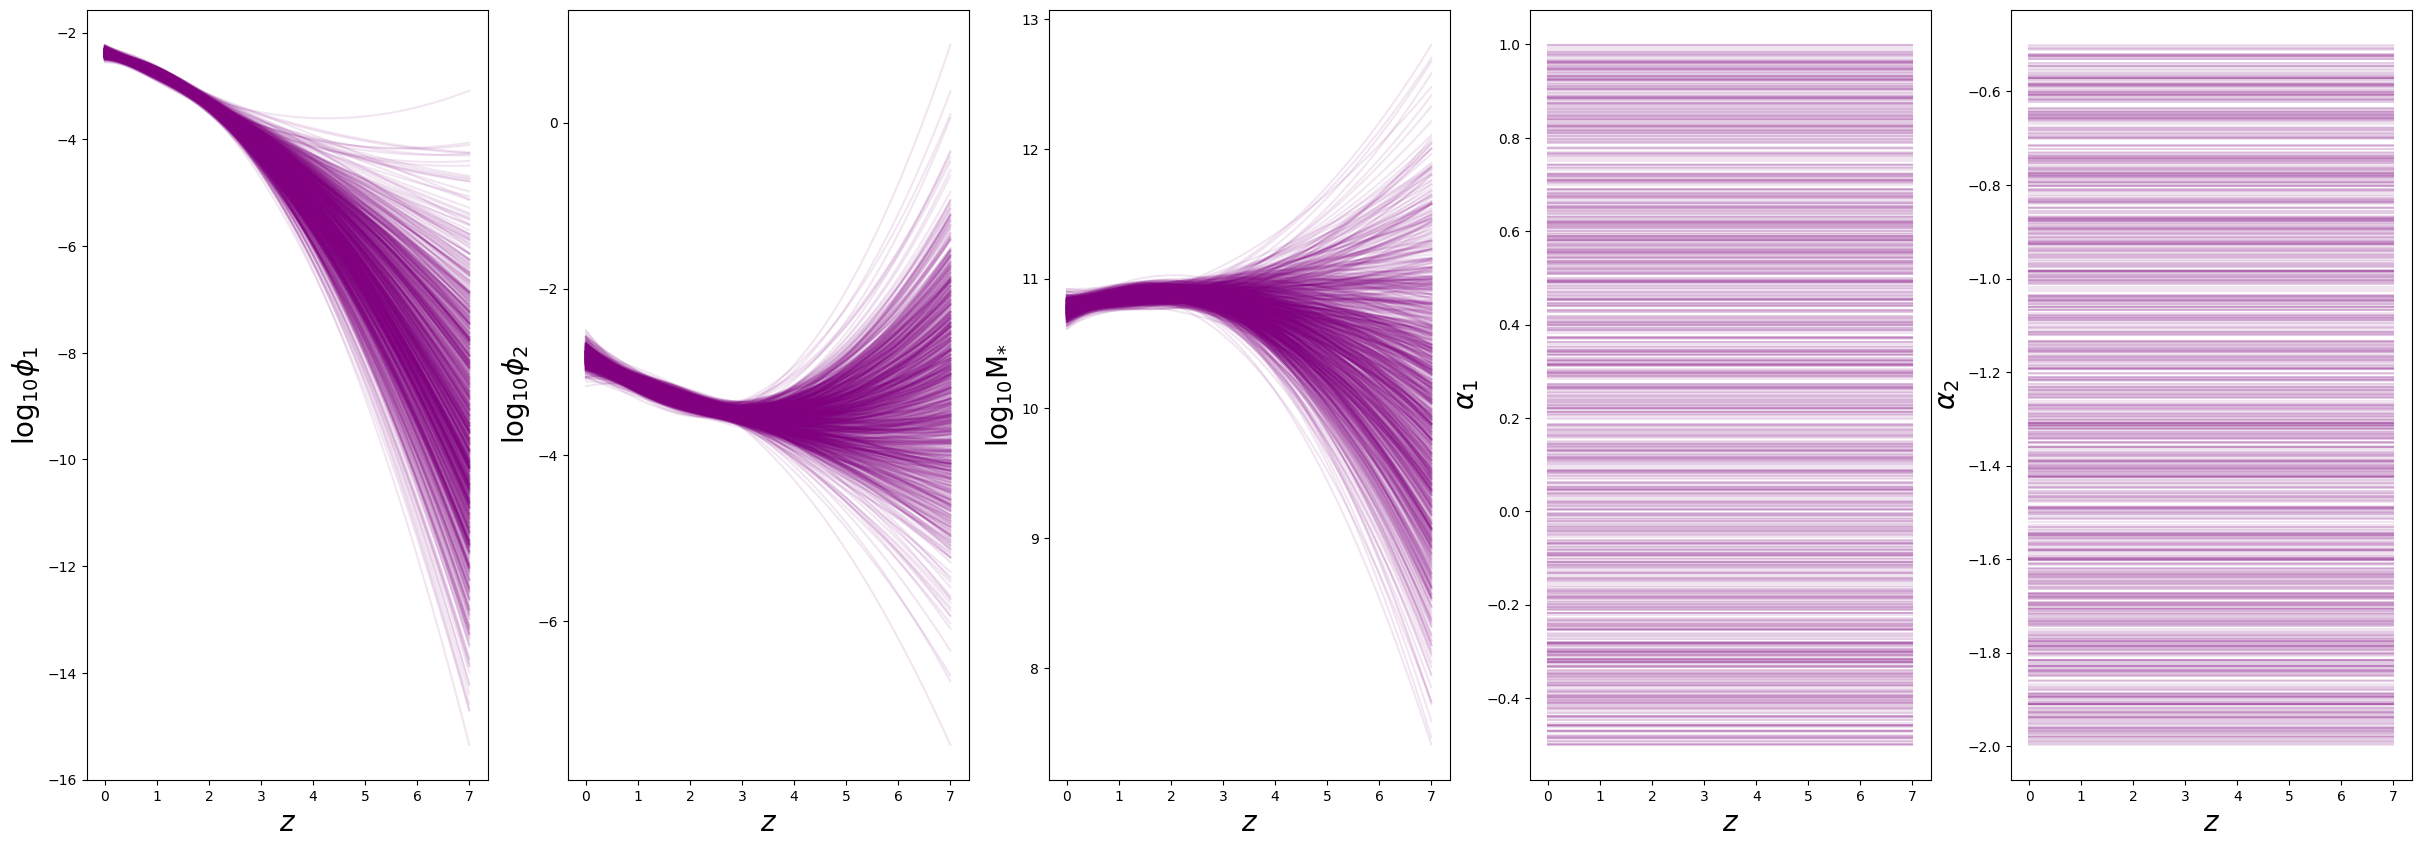

In [15]:
z_grid = np.linspace(0.0, 7.0, 100)
plot_mass_function_parameter_curves(z_grid, mass_function_parameter_curves(z_grid, 1000, truth=False), alpha=0.1)

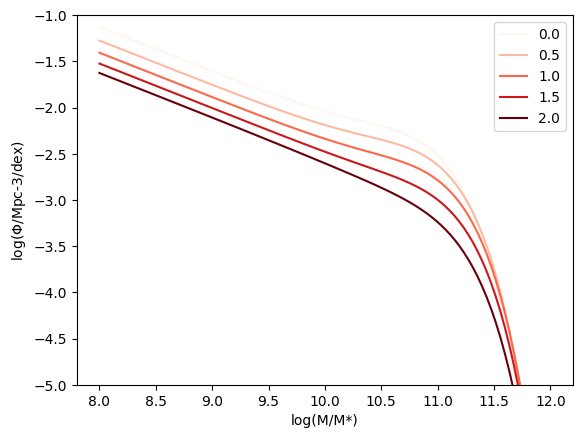

In [16]:
plot_observed_mass_function()

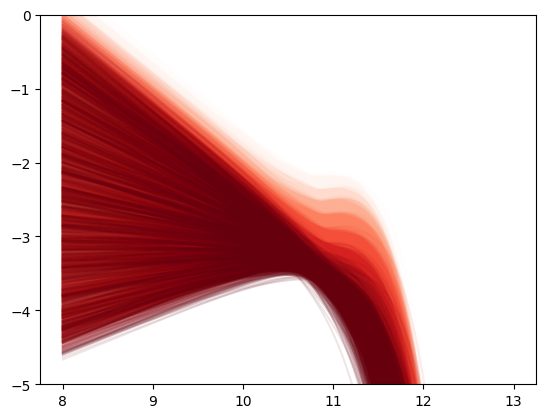

In [17]:
plot_mass_function_curves()

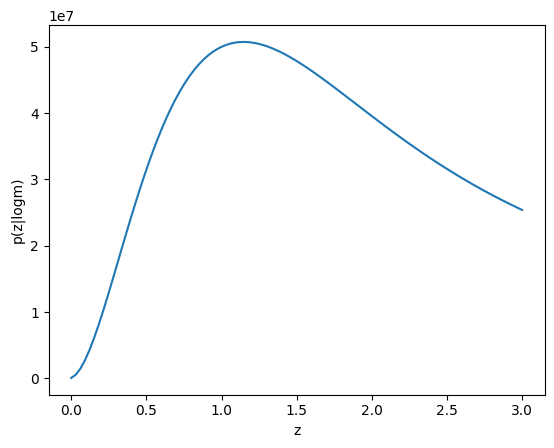

In [18]:
plot_observed_nz()

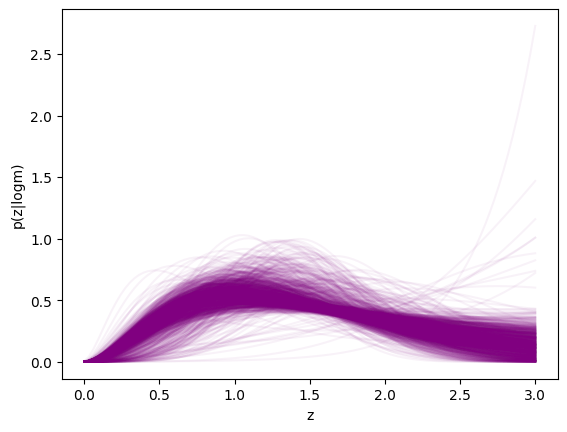

In [19]:
z_grid = np.linspace(0.0, 3.0, 100)
logm_grid = np.linspace(10, 12, 10)
nsamples=100
plot_nzs(z_grid, logm_grid, nsamples)

In [20]:
def plot_nz_prior_draws(z_grid, logm_grid, nsamples):
    i = 0
    while(i < nsamples):
        plt.plot(z_grid, draw_nz_prior(z_grid, logm_grid), alpha=0.1, c='purple')
        i+=1

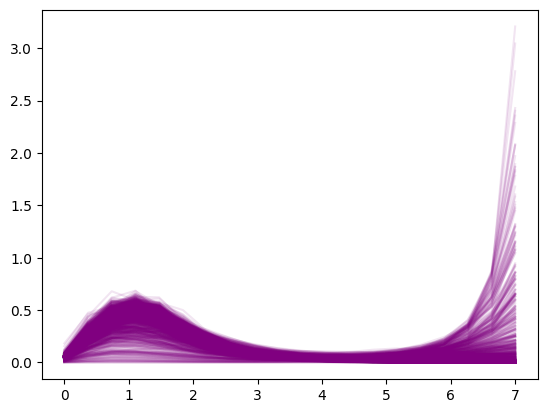

In [21]:
z_grid = np.linspace(0.0, 7.0, 20)
logm_grid = np.linspace(10, 12, 5)
plot_nz_prior_draws(z_grid, logm_grid, 1000)

In [22]:
n = len(z_grid)
dz = z_grid[-1]-z_grid[-2]
z_grid = np.concatenate((z_grid, np.array([z_grid[-1]+dz])))

i = 0
volumes = []
while(i < n):
    dv = WMAP9.comoving_volume(z_grid[i+1]).value - WMAP9.comoving_volume(z_grid[i]).value
    volumes.append(dv)

    i+=1
